<a href="https://colab.research.google.com/github/evyatar1322/Deep-learning-project/blob/main/Calculating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <img src="https://img.icons8.com/bubbles/50/000000/mind-map.png" style="height:50px;display:inline"> **ECE 046211 - Technion - Deep Learning - Final Project**
---

## **Solving Handwritten Math Exercises**
Reut Cohen & Evyatar Cohen

---
**Using YOLOv10 Model to solving handwritten math exercises**


**Imports**

In [1]:
# imports

import zipfile
import os
import random
import shutil
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch

In [2]:
# login google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Load trained model**

In [3]:
!unzip /content/drive/My\ Drive/session_backup.zip -d /content/runs

Archive:  /content/drive/My Drive/session_backup.zip
   creating: /content/runs/detect/
   creating: /content/runs/detect/train/
   creating: /content/runs/detect/train/weights/
  inflating: /content/runs/detect/train/train_batch57227.jpg  
  inflating: /content/runs/detect/train/val_batch1_labels.jpg  
  inflating: /content/runs/detect/train/events.out.tfevents.1723334978.52395a5d14fa.3671.0  
  inflating: /content/runs/detect/train/args.yaml  
  inflating: /content/runs/detect/train/val_batch2_labels.jpg  
  inflating: /content/runs/detect/train/results.png  
  inflating: /content/runs/detect/train/train_batch0.jpg  
  inflating: /content/runs/detect/train/F1_curve.png  
  inflating: /content/runs/detect/train/confusion_matrix_normalized.png  
  inflating: /content/runs/detect/train/val_batch2_pred.jpg  
  inflating: /content/runs/detect/train/R_curve.png  
  inflating: /content/runs/detect/train/train_batch57225.jpg  
  inflating: /content/runs/detect/train/results.csv  
  inflating

In [4]:
# Install necessary libraries
!pip install -q ultralytics

# Load trained model
from ultralytics import YOLO

model = YOLO('/content/runs/detect/train/weights/best.pt')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.6/865.6 kB 36.2 MB/s eta 0:00:00


**Backup test images**

In [28]:
def backup_test():
    # Define the name and path of the zip file
    zip_filename = "/content/drive/My Drive/test_backup.zip"
    # Create a zip archive of the entire /content/ directory
    shutil.make_archive(zip_filename.replace('.zip', ''), 'zip', "/content/test")
    print("test backed up at", time.ctime())

In [29]:
backup_test()

test backed up at Tue Aug 13 15:41:34 2024


In [30]:
!unzip /content/drive/My\ Drive/test_backup.zip -d /content/test

**Scripts for calculating**

In [6]:
## Sorting the classes from left to right from YOLO

def model_imeage_cls_from_left_to_right(results):
  # Assuming results[0].boxes contains the bounding boxes information
  # Format of boxes: tensor([xmin, ymin, xmax, ymax])
  cls = results[0].boxes.cls  # Tensor containing class IDs
  boxes = results[0].boxes.xyxyn  # Tensor containing bounding boxes

  # Combine class IDs with xmin to sort
  xmin_cls_pairs = torch.stack((boxes[:, 0], cls), dim=1)  # Stack xmin and cls

  # Sort based on xmin
  sorted_pairs = xmin_cls_pairs[xmin_cls_pairs[:, 0].argsort()]

  # Extract the sorted class IDs
  sorted_cls = sorted_pairs[:, 1]
  sorted_cls = sorted_cls.tolist()
  list_sorted_cls = [int(y) for y in sorted_cls]
  return [list_sorted_cls, sorted_cls  ]

In [7]:
## Sorting the classes from left to right from file name

def filename_to_class_ids(filename):
    # Mapping from character to class ID
    char_to_class_id = {
        '0': 0, '1': 1, '2': 2, '3': 3, '4': 4,
        '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
        'add': 10, 'sub': 11, 'mul': 12, 'div': 13, 'eq': 14
    }

    # Initialize an empty list to store class IDs
    class_ids = []

    # Start scanning the filename from the beginning
    i = 0
    while i < len(filename):
        # Check for two-character symbols first (to avoid partial matches like 'sub' being treated as 'su' + 'b')
        if filename[i:i+3] == 'add':
            class_ids.append(char_to_class_id['add'])
            i += 3  # Skip the length of 'add'
        elif filename[i:i+3] == 'sub':
            class_ids.append(char_to_class_id['sub'])
            i += 3  # Skip the length of 'sub'
        elif filename[i:i+3] == 'mul':
            class_ids.append(char_to_class_id['mul'])
            i += 3  # Skip the length of 'mul'
        elif filename[i:i+3] == 'div':
            class_ids.append(char_to_class_id['div'])
            i += 3  # Skip the length of 'div'
        elif filename[i:i+2] == 'eq':
            class_ids.append(char_to_class_id['eq'])
            i += 3  # Skip the length of 'eq'
        elif filename[i:i+1] in char_to_class_id:
            # Single digit or single operator
            class_ids.append(char_to_class_id[filename[i]])
            i += 1  # Move to the next character
        else:
            # If the current substring does not match, just skip one character
            # This might be part of a multi-character symbol like operators
            i += 1

    return class_ids

In [8]:
## Checking classifaction success

def check_classifaction_success (filename , results):
  Real_class_ids  =  filename_to_class_ids(filename)
  YOLO_class_ids , _  = model_imeage_cls_from_left_to_right(results)

  if Real_class_ids == YOLO_class_ids:
    print ('success classifacation on image - ' ,filename)
    print('class_ids:', YOLO_class_ids)
    return 1
  else:
    print('miss classifacation on image - ' ,filename)
    print('Real_class_ids:', Real_class_ids)
    print('YOLO_class_ids:', YOLO_class_ids)
    return 0



In [9]:
## Calculating accurancy

def calc_accurancy (succes, num_of_images):
  accurancy = succes/num_of_images
  print ("num_of_images:" ,num_of_images , "success:", succes)
  print ("test accurancy:" , accurancy*100 , "%" )


In [10]:
## Solving expression

def solve_expression(class_ids):
    # Mapping from class ID back to character
    id_to_char = {
        0: '0', 1: '1', 2: '2', 3: '3', 4: '4',
        5: '5', 6: '6', 7: '7', 8: '8', 9: '9',
        10: '+', 11: '-', 12: '*', 13: '/', 14: '='
    }

    # Convert class IDs to characters
    characters = [id_to_char[id] for id in class_ids]

    # Combine consecutive digits into single numbers
    expression = ""
    i = 0
    while i < len(characters):
        if characters[i].isdigit():
            # Start a new number
            number = characters[i]
            i += 1
            while i < len(characters) and characters[i].isdigit():
                number += characters[i]
                i += 1
            expression += number
        else:
            expression += characters[i]
            i += 1

    expression = expression.replace('=', '')

    # Evaluate the expression safely using eval
    try:
        result = eval(expression)
    except Exception as e:
        result = f"Error evaluating expression: {e}"

    return expression, result

**testing handwritten math expressions**

In [12]:
## testing created expression (from same data)

succes = 0

# Run inference on an image
test_path = "/content/test/created_test3"
test_images = [img for img in os.listdir(test_path) if img.endswith(('.png', '.jpg', '.jpeg'))]
for img_name in test_images:
    image_path = os.path.join(test_path, img_name)
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_h, img_w = img.shape
    result = model.predict(source= image_path, conf=0.6, imgsz=[128,128*20])
    list_sorted_cls, sorted_cls   = model_imeage_cls_from_left_to_right(result)
    print(list_sorted_cls)
    succes += check_classifaction_success(img_name , result)
    expression, sol = solve_expression(list_sorted_cls)
    print(f"Expression: {expression} = {sol}")

    #print(result[0].boxes)

    # Convert results to image format suitable for display
    img_with_boxes = result[0].plot()

    # Display the image using matplotlib
    plt.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Hide axes
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [13]:
num_of_images = len([name for name in os.listdir(test_path) if os.path.isfile(os.path.join(test_path, name))])
print ("for created expression from same dataset:")
calc_accurancy(succes,num_of_images)

for created expression from same dataset:
num_of_images: 500 success: 482
test accurancy: 96.39999999999999 %


In [26]:
#checking created expression (other data)

succes = 0

# Run inference on an image
test_path = "/content/test/created_test2"
test_images = [img for img in os.listdir(test_path) if img.endswith(('.png', '.jpg', '.jpeg'))]
for img_name in test_images:
    image_path = os.path.join(test_path, img_name)
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_h, img_w = img.shape
    result = model.predict(source= image_path, conf=0.4, imgsz=[128,128*20])
    list_sorted_cls, sorted_cls   = model_imeage_cls_from_left_to_right(result)
    print(list_sorted_cls)
    succes += check_classifaction_success(img_name , result)
    expression, sol = solve_expression(list_sorted_cls)
    print(f"Expression: {expression} = {sol}")

    #print(result[0].boxes)

    # Convert results to image format suitable for display
    img_with_boxes = result[0].plot()

    # Display the image using matplotlib
    plt.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Hide axes
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [27]:
num_of_images = len([name for name in os.listdir(test_path) if os.path.isfile(os.path.join(test_path, name))])
print ("for created expression from other dataset:")
calc_accurancy(succes,num_of_images)

for created expression from other dataset:
num_of_images: 500 success: 447
test accurancy: 89.4 %



image 1/1 /content/test2/our_resized_test/112sub93mul4eq.png: 160x992 1 2, 1 3, 2 4s, 1 9, 1 sub, 1 mul, 1 eq, 504.6ms
Speed: 4.0ms preprocess, 504.6ms inference, 0.4ms postprocess per image at shape (1, 3, 160, 992)
[4, 2, 11, 9, 3, 12, 4, 14]
miss classifacation on image -  112sub93mul4eq.png
Real_class_ids: [1, 1, 2, 11, 9, 3, 12, 4, 14]
YOLO_class_ids: [4, 2, 11, 9, 3, 12, 4, 14]
Expression: 42-93*4 = -330


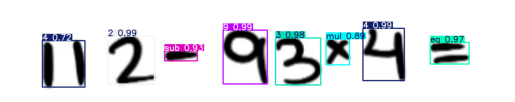


image 1/1 /content/test2/our_resized_test/2add22mul3sub12div4eq.png: 160x1280 1 1, 4 2s, 1 3, 1 4, 1 add, 1 sub, 1 mul, 1 div, 1 eq, 592.8ms
Speed: 2.6ms preprocess, 592.8ms inference, 0.3ms postprocess per image at shape (1, 3, 160, 1280)
[2, 10, 2, 2, 12, 3, 11, 1, 2, 13, 4, 14]
success classifacation on image -  2add22mul3sub12div4eq.png
class_ids: [2, 10, 2, 2, 12, 3, 11, 1, 2, 13, 4, 14]
Expression: 2+22*3-12/4 = 65.0


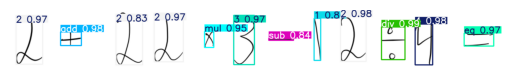


image 1/1 /content/test2/our_resized_test/4add20div5sub8eq.png: 160x992 1 0, 1 2, 1 4, 1 5, 1 8, 1 add, 1 sub, 1 div, 1 eq, 473.6ms
Speed: 1.8ms preprocess, 473.6ms inference, 0.3ms postprocess per image at shape (1, 3, 160, 992)
[4, 10, 2, 0, 13, 5, 11, 8, 14]
success classifacation on image -  4add20div5sub8eq.png
class_ids: [4, 10, 2, 0, 13, 5, 11, 8, 14]
Expression: 4+20/5-8 = 0.0


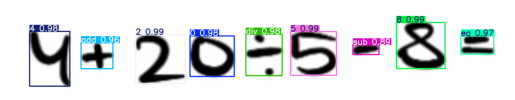


image 1/1 /content/test2/our_resized_test/72div8add10eq.png: 160x736 1 0, 1 1, 1 2, 1 7, 1 8, 1 add, 1 div, 1 eq, 348.4ms
Speed: 1.5ms preprocess, 348.4ms inference, 0.3ms postprocess per image at shape (1, 3, 160, 736)
[7, 2, 13, 8, 10, 1, 0, 14]
success classifacation on image -  72div8add10eq.png
class_ids: [7, 2, 13, 8, 10, 1, 0, 14]
Expression: 72/8+10 = 19.0


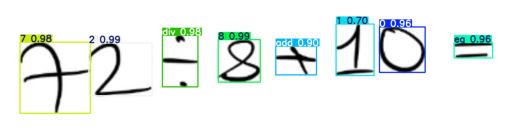


image 1/1 /content/test2/our_resized_test/40mul5eq.png: 160x640 1 0, 1 4, 1 5, 1 mul, 1 eq, 346.2ms
Speed: 1.3ms preprocess, 346.2ms inference, 0.3ms postprocess per image at shape (1, 3, 160, 640)
[4, 0, 12, 5, 14]
success classifacation on image -  40mul5eq.png
class_ids: [4, 0, 12, 5, 14]
Expression: 40*5 = 200


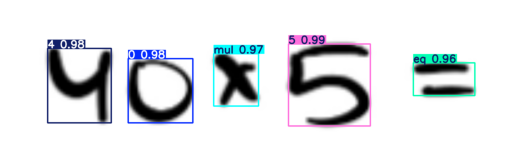


image 1/1 /content/test2/our_resized_test/6mul3sub3mul6eq.png: 160x896 2 3s, 2 6s, 1 sub, 2 muls, 1 eq, 458.6ms
Speed: 1.8ms preprocess, 458.6ms inference, 0.5ms postprocess per image at shape (1, 3, 160, 896)
[6, 12, 3, 11, 3, 12, 6, 14]
success classifacation on image -  6mul3sub3mul6eq.png
class_ids: [6, 12, 3, 11, 3, 12, 6, 14]
Expression: 6*3-3*6 = 0


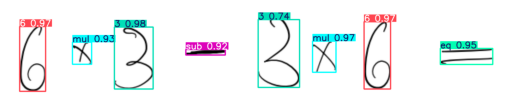


image 1/1 /content/test2/our_resized_test/23sub45div9mul2add67add81eq.png: 160x1600 1 1, 2 2s, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 2 adds, 1 sub, 1 mul, 1 div, 1 eq, 1133.7ms
Speed: 4.2ms preprocess, 1133.7ms inference, 0.4ms postprocess per image at shape (1, 3, 160, 1600)
[2, 3, 11, 4, 5, 13, 9, 12, 2, 10, 6, 7, 10, 8, 1, 14]
success classifacation on image -  23sub45div9mul2add67add81eq.png
class_ids: [2, 3, 11, 4, 5, 13, 9, 12, 2, 10, 6, 7, 10, 8, 1, 14]
Expression: 23-45/9*2+67+81 = 161.0


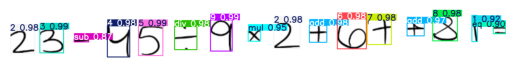


image 1/1 /content/test2/our_resized_test/2div4mul6eq.png: 160x672 1 2, 1 4, 1 6, 1 mul, 1 div, 1 eq, 518.2ms
Speed: 2.0ms preprocess, 518.2ms inference, 0.4ms postprocess per image at shape (1, 3, 160, 672)
[2, 13, 4, 12, 6, 14]
success classifacation on image -  2div4mul6eq.png
class_ids: [2, 13, 4, 12, 6, 14]
Expression: 2/4*6 = 3.0


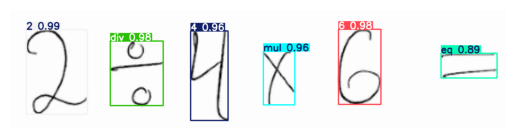


image 1/1 /content/test2/our_resized_test/12sub44add79add88div4add2eq.png: 160x1408 1 1, 2 2s, 3 4s, 1 7, 2 8s, 1 9, 3 adds, 1 div, 1 eq, 1031.7ms
Speed: 3.7ms preprocess, 1031.7ms inference, 0.5ms postprocess per image at shape (1, 3, 160, 1408)
[1, 2, 4, 4, 10, 7, 9, 10, 8, 8, 13, 4, 10, 2, 14]
miss classifacation on image -  12sub44add79add88div4add2eq.png
Real_class_ids: [1, 2, 11, 4, 4, 10, 7, 9, 10, 8, 8, 13, 4, 10, 2, 14]
YOLO_class_ids: [1, 2, 4, 4, 10, 7, 9, 10, 8, 8, 13, 4, 10, 2, 14]
Expression: 1244+79+88/4+2 = 1347.0


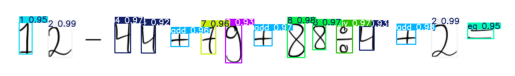


image 1/1 /content/test2/our_resized_test/5mul5mul5mul5mul5add1eq.png: 160x1184 1 1, 5 5s, 1 add, 4 muls, 1 eq, 549.0ms
Speed: 2.1ms preprocess, 549.0ms inference, 0.4ms postprocess per image at shape (1, 3, 160, 1184)
[5, 12, 5, 12, 5, 12, 5, 12, 5, 10, 1, 14]
success classifacation on image -  5mul5mul5mul5mul5add1eq.png
class_ids: [5, 12, 5, 12, 5, 12, 5, 12, 5, 10, 1, 14]
Expression: 5*5*5*5*5+1 = 3126


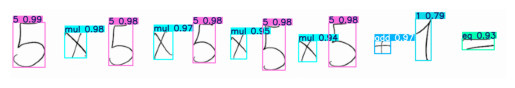

In [24]:
succes = 0

# Run inference on an image
test_path = "/content/test/our_test"
os.makedirs("/content/test/our_resized_test", exist_ok=True)
test_images = [img for img in os.listdir(test_path) if img.endswith(('.png', '.jpg', '.jpeg'))]
for img_name in test_images:
    image_path = os.path.join(test_path, img_name)
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_h, img_w = img.shape
    resized_img = cv2.resize(img, (int((img_w/img_h)*500), 500))
    resized_img_h, resized_img_w = resized_img.shape
    resized_path = os.path.join("/content/test/our_resized_test", img_name)
    cv2.imwrite(resized_path, resized_img)
    result = model.predict(source= resized_path, conf=0.5, imgsz=[160,128*20])
    list_sorted_cls, sorted_cls   = model_imeage_cls_from_left_to_right(result)
    print(list_sorted_cls)
    succes += check_classifaction_success(img_name , result)
    expression, sol = solve_expression(list_sorted_cls)
    print(f"Expression: {expression} = {sol}")

    #print(result[0].boxes)

    # Convert results to image format suitable for display
    img_with_boxes = result[0].plot()

    # Display the image using matplotlib
    plt.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Hide axes
    plt.show()

In [25]:
num_of_images = len([name for name in os.listdir(test_path) if os.path.isfile(os.path.join(test_path, name))])
print ("for our expression:")
calc_accurancy(succes,num_of_images)

for our expression:
num_of_images: 10 success: 8
test accurancy: 80.0 %


If you want to using the model on your exercises, please take the code of test and change the path

## <img src="https://img.icons8.com/dusk/64/000000/prize.png" style="height:50px;display:inline"> Credits
---

* Model YOLO from <a href="https://https://github.com/THU-MIG/yolov10/tree/main/docs/en">YOLO</a> - https://github.com
* Datasets from <a href="https://www.kaggle.com/">Kaggle</a> - https://www.kaggle.com/